# Short Course: Machine Learning for Exploration Geophysics

Hamburg, 10. - 12. March 2020

#### Kaggle competition 2: Facies Classification

Table of Content:
- [Packages](#Packages)
- [Import the dataset](#Import-the-dataset)
- [Train-Test Split](#Train-Test-Split)
- [Random-Forest-model](#Random-Forest-model)
- [Save-submission](#Save-submission)
- [Plot-predicted-results](#Plot-predicted-results)

In [36]:
#!pip install pandas
#!pip install -U scikit-learn

#!python -m pip install -U pip
#!python -m pip install -U matplotlib

#!pip install pandas

#!pip install seaborn

#!pip install xgboost

In [37]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import xgboost

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

from utils import make_facies_log_plot, compare_facies_plot


import warnings
warnings.filterwarnings('ignore')

print('Pandas:  ' + pd.__version__)
print('Numpy:   ' + np.__version__)
print('Sklearn: ' + sklearn.__version__)

Pandas:  0.24.2
Numpy:   1.17.4
Sklearn: 0.22.2.post1


## Read the dataset

A comma-separated values (CSV) file is a type of plain text file that is widely supported by machine learning applications. We can read a CSV file using pandas [read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function into [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

In [38]:
df_train = pd.read_csv('data/train_fc.csv')
df_blind = pd.read_csv('data/test_fc.csv')

Let us first visualize a few examples to see what columns there are, what information they contain, how the values are coded. We could use the following methods: 

- [head(self, n)](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html#pandas.DataFrame.head) - Return the first n rows,
- [info](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html#pandas.DataFrame.info) - Print a concise summary of a DataFrame,
- [describe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html#pandas.DataFrame.describe) - Generate descriptive statistics.

In [39]:
df_train.head(10) #View first 10 data rows
#df_train.info()
#df_train.describe()

,Facies,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels
0,2,15_9_C,2774.5,98.36,0.642,-0.1,18.685,2.9,1,1.000,CSiS
1,2,15_9_C,2775.0,97.57,0.631,7.9,16.745,3.2,1,0.984,CSiS
2,2,15_9_C,2775.5,98.41,0.615,12.8,14.105,3.2,1,0.968,CSiS
3,2,15_9_C,2776.0,85.92,0.597,13.0,13.385,3.4,1,0.952,CSiS
4,2,15_9_C,2776.5,83.16,0.592,12.3,13.345,3.4,1,0.935,CSiS
5,2,15_9_C,2777.0,82.56,0.599,12.9,13.105,3.5,1,0.919,CSiS
6,2,15_9_C,2777.5,83.12,0.611,13.2,14.000,3.3,1,0.903,CSiS
7,2,15_9_C,2778.0,84.26,0.620,12.8,13.685,3.3,1,0.887,CSiS
8,2,15_9_C,2778.5,86.29,0.627,13.2,13.920,3.2,1,0.871,CSiS
9,2,15_9_C,2779.0,80.95,0.629,13.0,13.975,3.2,1,0.855,CSiS


In [40]:
df_blind.head(10) #View first 10 data rows
#df_train.info()
#df_train.describe()

,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels
0,15_9_A,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000,FSiS
1,15_9_A,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979,FSiS
2,15_9_A,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957,FSiS
3,15_9_A,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936,FSiS
4,15_9_A,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915,FSiS
5,15_9_A,2795.5,73.97,0.636,14.0,13.385,3.6,1,0.894,FSiS
6,15_9_A,2796.0,73.72,0.630,15.6,13.930,3.7,1,0.872,FSiS
7,15_9_A,2796.5,75.65,0.625,16.5,13.920,3.5,1,0.830,FSiS
8,15_9_A,2797.0,73.79,0.624,16.2,13.980,3.4,1,0.809,FSiS
9,15_9_A,2797.5,76.89,0.615,16.9,14.220,3.5,1,0.787,FSiS


Pandas dtype |Python type |NumPy type |Usage
:---: | :---: | :---: | :---:  
object |str | string_, unicode_ |Text
int64  |int | int_, int8, int16, int32, int64, uint8, uint16, uint32, uint64 | Integer numbers
float64 |float | float_, float16, float32, float64 | Floating point numbers
bool | bool | bool_ |True/False values
datetime64 | NA | datetime64 |Date and time values
timedelta | NA | NA | Differences between two datetimes
category | NA | NA | Finite list of text values

In [41]:
well = df_train['Well Name']
List_of_well_names = well.unique()

feature_names = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']
facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D','PS', 'BS']

facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]
    
print('List of well names: ' + str(List_of_well_names))

List of well names: ['15_9_C' '15_9_D' '15_9_F' '15_9_G' '15_9_I' '15_9_K']


Facies # | Name | Facies Labels
:---: | :---: | :---: 
1 | sandstone  | SS
2 | c_siltstone |  CSiS
3 | f_siltstone |FSiS
4 | marine_silt_shale | SiSh 
5 | mudstone | MS
6 | wackestone | WS
7 | dolomite | D
8 | packstone | PS
9 | bafflestone | BS
                

## Make the data

In [42]:
y = df_train['FaciesLabels'].values
X = df_train[feature_names].values 

## Visualize the data

### Plot well logs

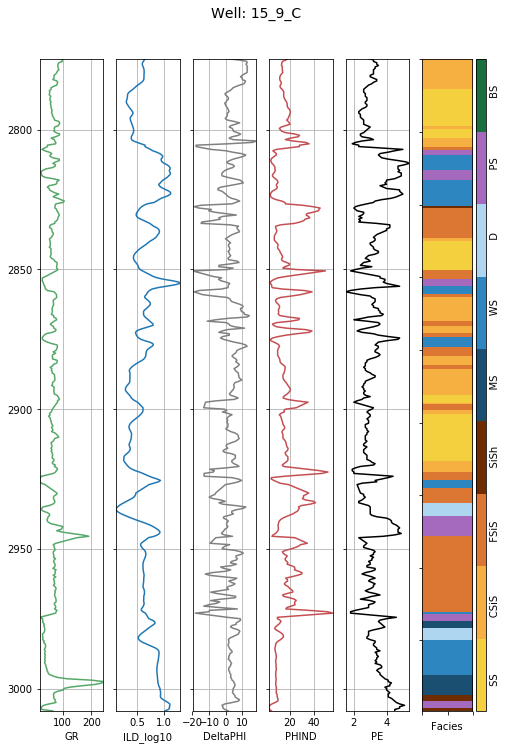

In [43]:
make_facies_log_plot(df_train[df_train['Well Name'] == '15_9_C'], facies_colors)

### The number of unique entries for each facies

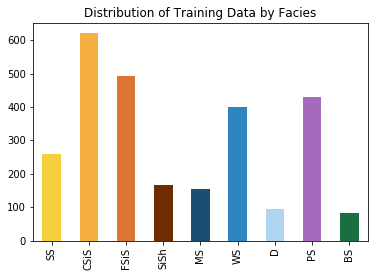

In [44]:
facies_counts = df_train['Facies'].value_counts().sort_index()
#use facies labels to index each count
facies_counts.index = facies_labels
facies_counts.plot(kind='bar',color=facies_colors, title='Distribution of Training Data by Facies')

### Plot pairwise relationships in a dataset

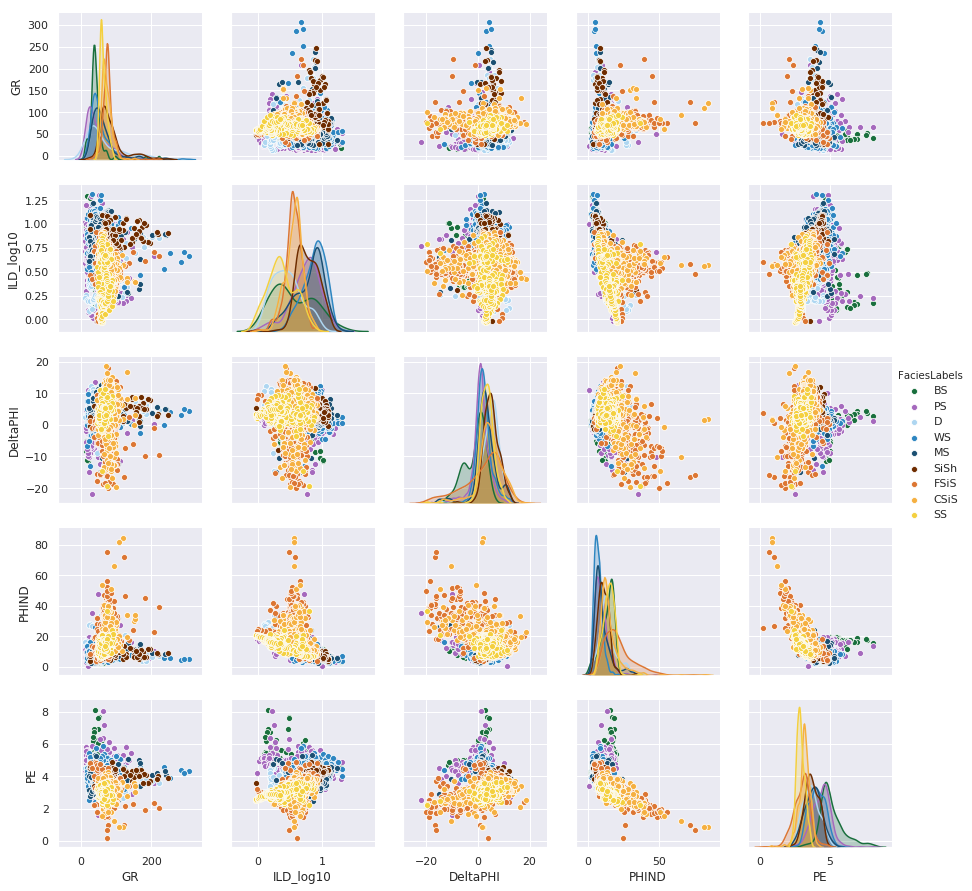

In [45]:
inline_rc = dict(mpl.rcParams)

sns.set()
sns.pairplot(df_train.drop(['Well Name','Facies','Depth','NM_M','RELPOS'],axis=1),
             hue='FaciesLabels', palette=facies_color_map,
             hue_order=list(reversed(facies_labels)))
mpl.rcParams.update(inline_rc)

### Facies per well

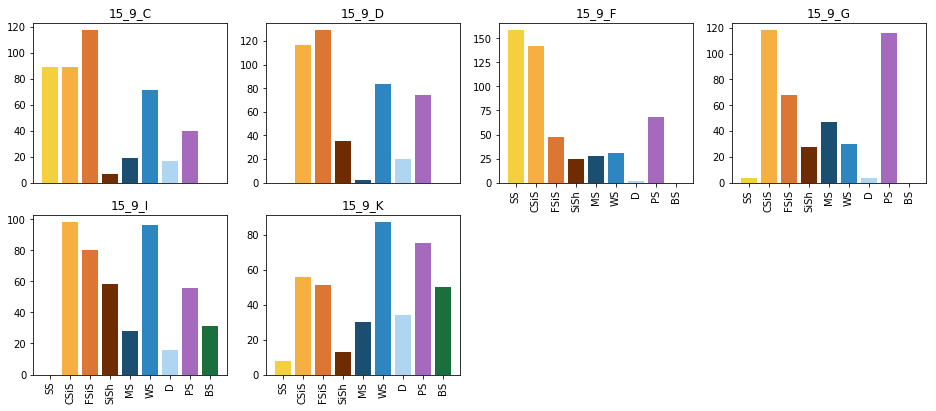

In [46]:
y_plot = df_train['Facies'].values

fig = plt.gcf()
fig.set_size_inches(16, 10)
for w_idx, w in enumerate(np.unique(well)):
    ax = plt.subplot(3, 4, w_idx+1)
    hist = np.histogram(y_plot[well == w], bins=np.arange(len(facies_labels)+1)+.5)
    plt.bar(np.arange(len(hist[0])), hist[0], color=facies_colors, align='center')
    ax.set_xticks(np.arange(len(hist[0])))
    ax.set_xticklabels(facies_labels)
    plt.xticks(rotation=90)
    if w_idx < 2:
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.set_title(w)

### Features per well

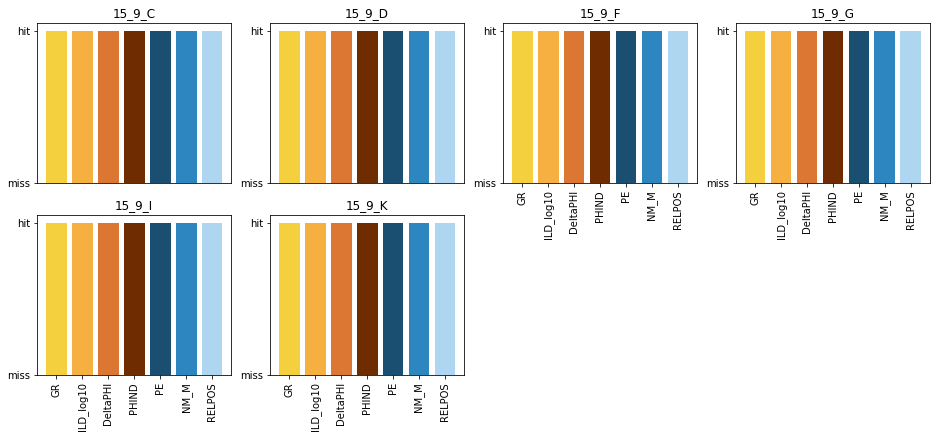

In [47]:
fig = plt.gcf()
fig.set_size_inches(16, 10)
for w_idx, w in enumerate(np.unique(well)):
    ax = plt.subplot(3, 4, w_idx+1)
    hist = np.logical_not(np.any(np.isnan(X[well == w, :]), axis=0))
    plt.bar(np.arange(len(hist)), hist, color=facies_colors, align='center')
    ax.set_xticks(np.arange(len(hist)))
    ax.set_xticklabels(feature_names)
    ax.set_yticks([0, 1])
    plt.xticks(rotation=90)
    ax.set_yticklabels(['miss', 'hit'])
    if w_idx < 2:
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.set_title(w)

## Data Preprocessing

In [48]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state=42)

## CV Grid Search

In [49]:
def grid_search(clf, param_grid, X_train, y_train):
    
    kfold = KFold(n_splits=5, shuffle=True)
    
    grid = GridSearchCV(estimator = clf, 
                        param_grid = param_grid, 
                        scoring = 'f1_macro', 
                        cv = kfold)
    grid.fit(X_train, y_train)
    print('F1 score: %.2f' %grid.best_score_)
    
    return grid.best_estimator_

## Support vector machine classifier

In [50]:
clf = SVC()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

#y_pred.shape
y_test.shape

(539,)

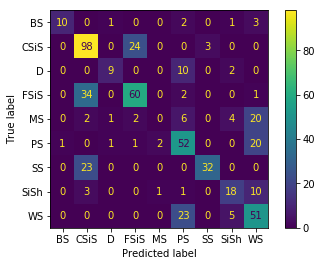

In [51]:
plot_confusion_matrix(clf, X_test, y_test)

In [52]:
print('F1 score = %.2f' % f1_score(y_test,y_pred, average='micro'))

F1 score = 0.61


## Find the best hyperparameters

In [53]:
clf = SVC()
param_grid = {'C' : [.01, 1, 5, 10, 20, 50, 100, 1000, 5000, 10000]}
clf_best = grid_search(clf, param_grid, X_train, y_train)
#clf_best = grid_search(clf, {}, X_train, y_train)
y_pred = clf_best.predict(X_test)
print('F1 score = %.2f' % f1_score(y_test,y_pred, average='macro'))
print('Optimal C = %.2f:' % clf_best.C)

F1 score: 0.67
F1 score = 0.70
Optimal C = 10000.00:


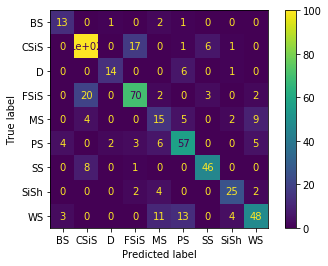

In [54]:
plot_confusion_matrix(clf_best, X_test, y_test)

## Applying the classification model to the blind data

In [55]:
df_blind.head(10)

,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels
0,15_9_A,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000,FSiS
1,15_9_A,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979,FSiS
2,15_9_A,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957,FSiS
3,15_9_A,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936,FSiS
4,15_9_A,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915,FSiS
5,15_9_A,2795.5,73.97,0.636,14.0,13.385,3.6,1,0.894,FSiS
6,15_9_A,2796.0,73.72,0.630,15.6,13.930,3.7,1,0.872,FSiS
7,15_9_A,2796.5,75.65,0.625,16.5,13.920,3.5,1,0.830,FSiS
8,15_9_A,2797.0,73.79,0.624,16.2,13.980,3.4,1,0.809,FSiS
9,15_9_A,2797.5,76.89,0.615,16.9,14.220,3.5,1,0.787,FSiS


In [56]:
X_blind = df_blind[feature_names].values 
X_blind = scaler.transform(X_blind)
y_blind_pred = clf_best.predict(X_blind)

In [57]:
#sample_submission = pd.read_csv('data/sample_submission_fc.csv')

#new_submission = sample_submission
#new_submission['FaciesLabels'] = y_pred

#filename = 'new_submission_example_fc.csv'
#new_submission.to_csv(filename,index=False)
#print('Saved file: ' + filename)

### Score on blind dataset

In [58]:
df_y_blind = pd.read_csv('data/solution_fc.csv')
y_blind = df_y_blind['FaciesLabels'].values
print('F1 score on blind dataset = %.2f' % f1_score(y_blind,y_blind_pred, average='macro'))

F1 score on blind dataset = 0.31
